In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.optim as optim
import torchvision.datasets as datasets
import numpy as np
import matplotlib
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            # nz will be the input to the first convolution
            nn.ConvTranspose2d(
                nz, 512, kernel_size=4, 
                stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                512, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                256, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                128, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                64, 1, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                1, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                64, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                128, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                256, 512, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                512, 1, kernel_size=4, 
                stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
def label_real(size):
    """
    Fucntion to create real labels (ones)
    :param size: batch size
    :return real label vector
    """
    data = torch.ones(size, 1)
    return data.to(device)
def label_fake(size):
    """
    Fucntion to create fake labels (zeros)
    :param size: batch size
    :returns fake label vector
    """
    data = torch.zeros(size, 1)
    return data.to(device)

In [ ]:
def create_noise(sample_size, nz):
    """
    Fucntion to create noise
    :param sample_size: fixed sample size or batch size
    :param nz: latent vector size
    :returns random noise vector
    """
    return torch.randn(sample_size, nz, 1, 1).to(device)

In [ ]:
def save_generator_image(image, path):
    """
    Function to save torch image batches
    :param image: image tensor batch
    :param path: path name to save image
    """
    save_image(image, path, normalize=True)

In [ ]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
  # learning parameters / configurations according to paper
image_size = 64 # we need to resize image to 64x64
batch_size = 128
nz = 100 # latent vector size
beta1 = 0.5 # beta1 value for Adam optimizer
lr = 0.0002 # learning rate according to paper
sample_size = 64 # fixed sample size
epochs = 25 # number of epoch to train
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# image transform
transform = transforms.Compose([ transforms.Resize(image_size),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [ ]:
# prepare the data
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/train-images-idx3-ubyte.gz to ../input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/data/MNIST/raw



In [ ]:
# initialize models
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device) 

In [ ]:
# initialize generator weights
generator.apply(weights_init)
# initialize discriminator weights
discriminator.apply(weights_init)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
# loss function
criterion = nn.BCELoss()

In [ ]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    # get the fake label vector
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    # get the outputs by doing real data forward pass
    output_real = discriminator(data_real).view(-1)
    loss_real = criterion(output_real.squeeze(), real_label.squeeze())
    # get the outputs by doing fake data forward pass
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake.squeeze(), fake_label.squeeze())
    # compute gradients of real loss 
    loss_real.backward()
    # compute gradients of fake loss
    loss_fake.backward()
    # update discriminator parameters
    optimizer.step()
    return loss_real + loss_fake

In [ ]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    optimizer.zero_grad()
    # output by doing a forward pass of the fake data through discriminator
    output = discriminator(data_fake)
    loss = criterion(output.squeeze(), real_label.squeeze())
    # compute gradients of loss
    loss.backward()
    # update generator parameters
    optimizer.step()
    return loss 

In [ ]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [ ]:
generator.train()
discriminator.train()


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # forward pass through generator to create fake data
        data_fake = generator(create_noise(b_size, nz)).detach()
        data_real = image
        loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        loss_g += train_generator(optim_g, data_fake)
    # final forward pass through generator to create fake data...
    # ...after training for current epoch
    generated_img = generator(noise).cpu().detach()
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"./gen_img{epoch}.png")
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

469it [01:34,  4.94it/s]


Epoch 1 of 25
Generator loss: 6.13877869, Discriminator loss: 0.50466144


469it [01:27,  5.34it/s]


Epoch 2 of 25
Generator loss: 2.38908434, Discriminator loss: 0.97930580


469it [01:27,  5.34it/s]


Epoch 3 of 25
Generator loss: 2.59567857, Discriminator loss: 0.61343837


469it [01:27,  5.34it/s]


Epoch 4 of 25
Generator loss: 3.28192830, Discriminator loss: 0.52759558


469it [01:27,  5.33it/s]


Epoch 5 of 25
Generator loss: 3.42026234, Discriminator loss: 0.46668491


469it [01:27,  5.33it/s]


Epoch 6 of 25
Generator loss: 3.37083340, Discriminator loss: 0.45843238


469it [01:27,  5.34it/s]


Epoch 7 of 25
Generator loss: 3.38799191, Discriminator loss: 0.50232160


469it [01:27,  5.34it/s]


Epoch 8 of 25
Generator loss: 3.59961605, Discriminator loss: 0.38863999


469it [01:27,  5.34it/s]


Epoch 9 of 25
Generator loss: 3.31534934, Discriminator loss: 0.51260287


469it [01:27,  5.34it/s]


Epoch 10 of 25
Generator loss: 3.54880881, Discriminator loss: 0.42655861


469it [01:27,  5.33it/s]


Epoch 11 of 25
Generator loss: 3.51307726, Discriminator loss: 0.44926956


469it [01:27,  5.34it/s]


Epoch 12 of 25
Generator loss: 3.51571417, Discriminator loss: 0.48766664


469it [01:27,  5.34it/s]


Epoch 13 of 25
Generator loss: 4.07474899, Discriminator loss: 0.24162419


469it [01:27,  5.34it/s]


Epoch 14 of 25
Generator loss: 3.45543075, Discriminator loss: 0.57597095


469it [01:27,  5.34it/s]


Epoch 15 of 25
Generator loss: 3.48068213, Discriminator loss: 0.48793000


469it [01:27,  5.34it/s]


Epoch 16 of 25
Generator loss: 4.23524094, Discriminator loss: 0.26502961


469it [01:27,  5.34it/s]


Epoch 17 of 25
Generator loss: 4.30930042, Discriminator loss: 0.35560003


469it [01:27,  5.34it/s]


Epoch 18 of 25
Generator loss: 2.24201035, Discriminator loss: 0.84014404


469it [01:27,  5.34it/s]


Epoch 19 of 25
Generator loss: 3.84244061, Discriminator loss: 0.39231482


469it [01:27,  5.33it/s]


Epoch 20 of 25
Generator loss: 3.85193658, Discriminator loss: 0.35040829


469it [01:27,  5.34it/s]


Epoch 21 of 25
Generator loss: 3.80618453, Discriminator loss: 0.44278765


469it [01:27,  5.33it/s]


Epoch 22 of 25
Generator loss: 4.67934418, Discriminator loss: 0.26281232


469it [01:27,  5.34it/s]


Epoch 23 of 25
Generator loss: 3.29386544, Discriminator loss: 0.53173834


469it [01:27,  5.35it/s]


Epoch 24 of 25
Generator loss: 5.60280132, Discriminator loss: 0.01605579


 96%|█████████▌| 447/468 [01:23<00:03,  5.32it/s]

In [ ]:
losses_gt=torch.tensor(losses_g).to(torch.device("cpu"))
losses_dt=torch.tensor(losses_d).to(torch.device("cpu"))

In [ ]:
print('DONE TRAINING')
# save the model weights to disk
torch.save(generator.state_dict(), './generator.pth')

DONE TRAINING


In [ ]:
torch.save(discriminator.state_dict(), './discriminator.pth')

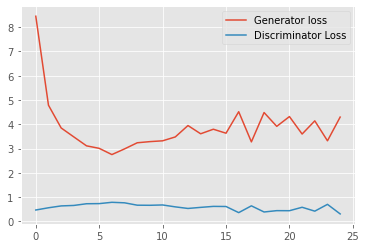

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_gt, label='Generator loss')
plt.plot(losses_dt, label='Discriminator Loss')
plt.legend()
plt.savefig('./loss.png')
plt.show()

Epoch 1


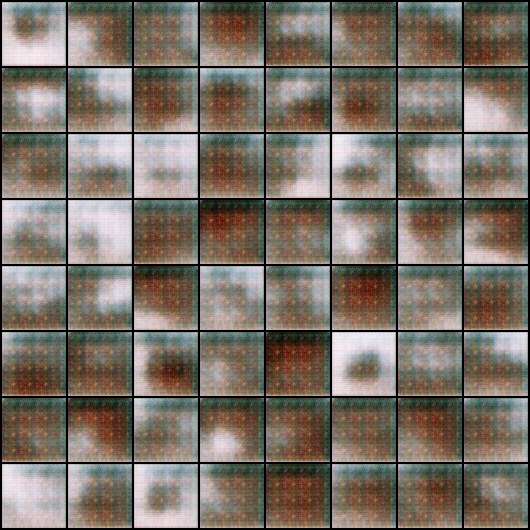




Epoch 5


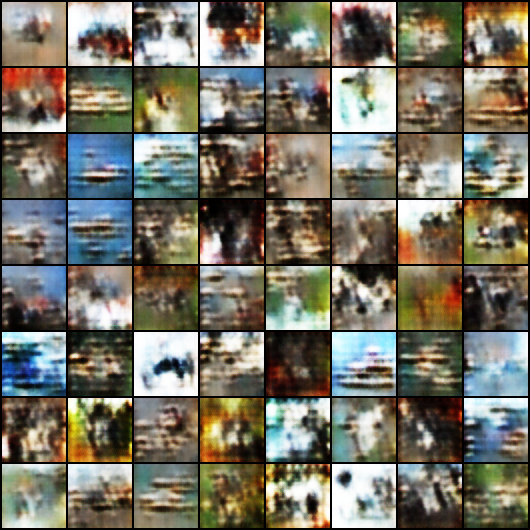




Epoch 10


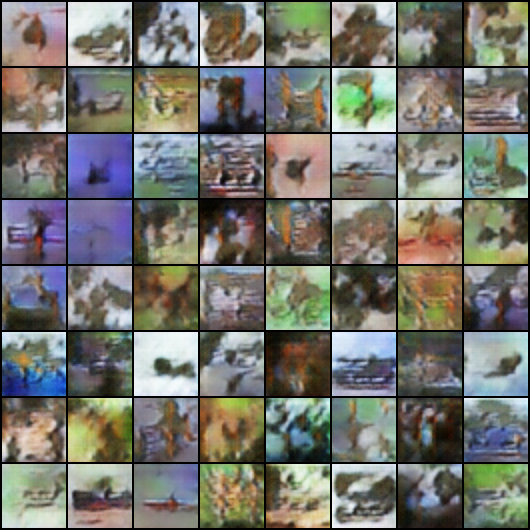




Epoch 15


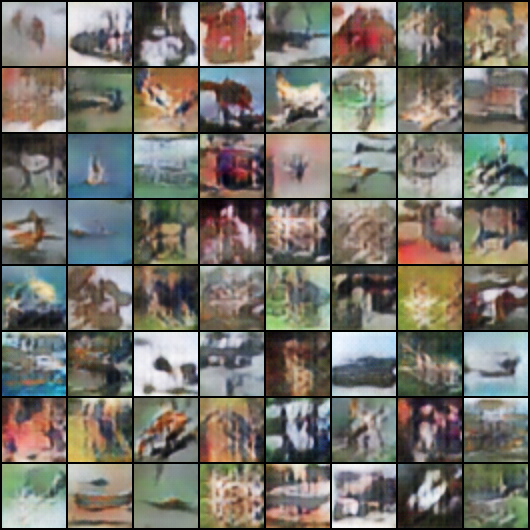




Epoch 20


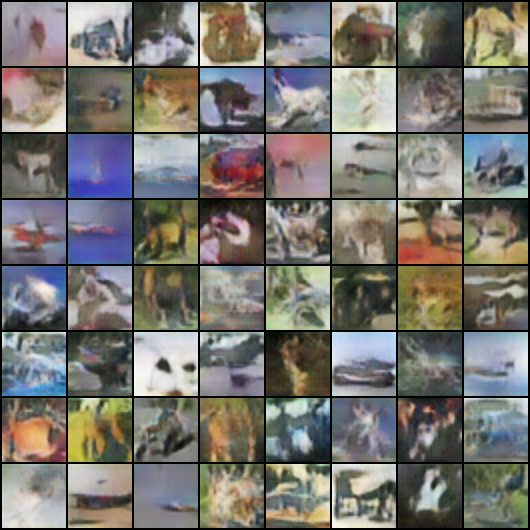




Epoch 25


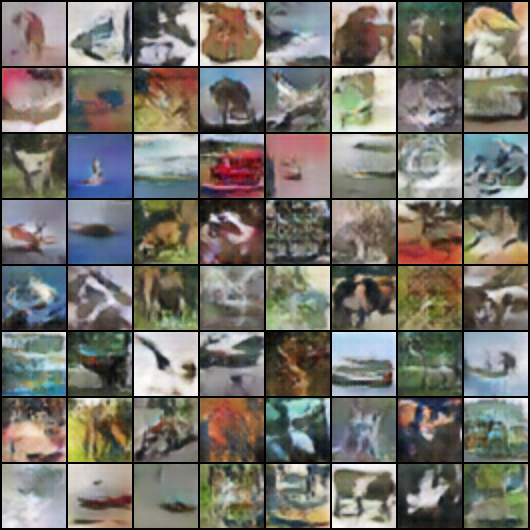

In [ ]:
from PIL import Image
import IPython.display as display

for step in [0,4,9,14,19,24]:
    print(f"Epoch {step+1}")
    path="gen_img"+str(step)+".png"
    display.display(Image.open(path))
    print("\n\n")
